# Examen práctico 
## Parcial 1 Laboratorio de Aprendizaje Estadístico
Diego Lozoya Morales | 745345

# Paqueterías

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsRegressor
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

# Funciones

In [14]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False)+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.figure(figsize=(10, 5))
    plt.plot(grouped.predicciones, grouped.y, label="Modelo", marker="o", color=colors[0])
    plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color=colors[1])
    plt.xlabel("Prediccion")
    plt.ylabel("Real")
    plt.title("Calibración")
    plt.grid()
    plt.legend()
    plt.show()

def vibariado(df, y):
    target = y.name
    num_vars = len(df.keys().drop(target))
    num_rows = (num_vars + 1) // 2 
    
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
    axes = axes.flatten()
    
    for idx, i in enumerate(df.keys().drop(target)):
        X = df[[i]]
        model = linear_model.LinearRegression().fit(X, y)
        
        q = len(X.iloc[:, 0].unique()) if len(X.iloc[:, 0].unique()) < 5 else 10
        df[i + "_bin"] = pd.qcut(df[i], q=q, labels=False, duplicates="drop") + 1
        grouped = df.groupby(i + "_bin").mean()
        
        ax = axes[idx]
        ax.plot(grouped[i].values, grouped[target].values, color=colors[0], marker='o')
        ax.set_xlabel(f"{i} bins")
        ax.set_ylabel(target)
        ax.set_title(f"Análisis bivariado entre {i} y {target}")
        ax.grid()
        
        df.drop(columns=[i + "_bin"], inplace=True)
    
    plt.tight_layout()
    plt.show()

def comparacion(modelos, y):
     plt.figure(figsize=(10, 5))

     for i, modelo in enumerate(modelos):
          col_pred = f'predicciones_{modelo}'

          df_calibracion = pd.DataFrame({
               'predicciones': globals()[col_pred],
               'y': y
          })

          df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=10, labels=False)+1
          grouped = df_calibracion.groupby('bins').mean()
          plt.plot(grouped['predicciones'].values, grouped['y'].values, marker='o', color=colors[i], label=modelos[i])

     plt.plot(grouped['predicciones'].values, grouped['predicciones'].values, color=colors[-1], linestyle="--", label="Real", zorder=100)
     plt.xlabel("Valores predichos")
     plt.ylabel("Valores reales")
     plt.title("Comparación de modelos")
     plt.grid()
     plt.legend()
     plt.show()

def graficas_KNN(resultados, nn_opt):
     fig, axes = plt.subplots(1, 2, figsize=(15, 5))  

     axes[0].plot(resultados.nn, resultados.r2, label='real', color=colors[0], marker='o')
     axes[0].grid()
     axes[0].set_title("$R^2$ Real")
     axes[0].set_xlabel("Nearest Neighbors")
     axes[0].set_ylabel("$R^2$")

     axes[1].plot(resultados.nn, resultados.r2_train, label='train', color=colors[1], marker='o')
     axes[1].grid()
     axes[1].set_title("$R^2$ Train")
     axes[1].set_xlabel("Nearest Neighbors")
     axes[1].set_ylabel("$R^2$")

     plt.show()

     plt.figure(figsize=(15, 5))
     plt.plot(resultados.nn, resultados.r2, label='Real', color=colors[0], marker='o')
     plt.plot(resultados.nn, resultados.r2_train, label='Train', color=colors[1], marker='o')
     plt.scatter(nn_opt, max(resultados.r2), label=f'Óptimo nn = {nn_opt}', color=colors[2], s=50, zorder=3)
     plt.text(nn_opt, max(resultados.r2)-0.05, f"Máximo $R^2$", va='bottom')
     plt.grid()
     plt.legend()
     plt.title("$R^2$ Real vs Train")
     plt.xlabel("Nearest Neighbors")
     plt.ylabel("$R^2$")
     plt.show()

# Data

In [15]:
data = pd.read_csv("Data/Boston.csv")
data.head()

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


## Explicación variables Dataset

CRIM - per capita crime rate by town

ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS - proportion of non-retail business acres per town.

CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

NOX - nitric oxides concentration (parts per 10 million)

RM - average number of rooms per dwelling

AGE - proportion of owner-occupied units built prior to 1940

DIS - weighted distances to five Boston employment centres

RAD - index of accessibility to radial highways

TAX - full-value property-tax rate per $10,000

PTRATIO - pupil-teacher ratio by town

LSTAT - % lower status of the population

MEDV - Median value of owner-occupied homes in $1000's

## Limpieza de datos

In [16]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


## Variable dependiente

In [17]:
target = 'medv'
y = data[target]

# Análisis Dataset

## Correlación

<Axes: >

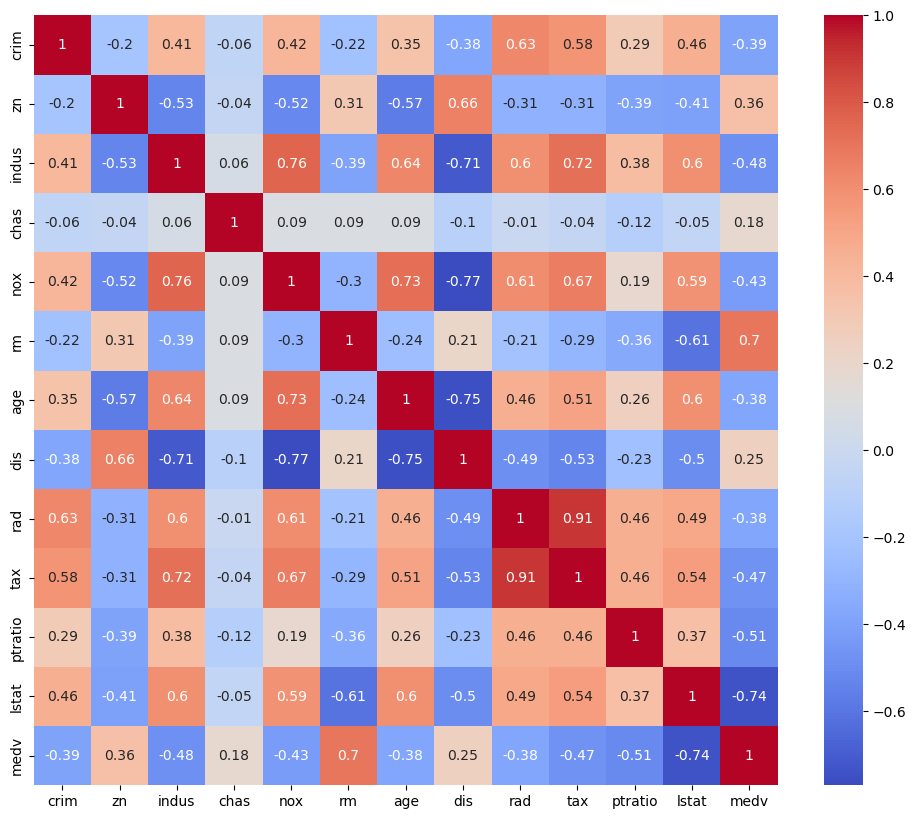

In [18]:
plt.figure(figsize=(12,10))
sns.heatmap(data.corr().round(2), annot=True, cmap="coolwarm")

In [19]:
pd.DataFrame(data.corr()[target]).sort_values(by=target, ascending=False).drop(index=target)

,medv
rm,0.695360
zn,0.360445
dis,0.249929
chas,0.175260
age,-0.376955
rad,-0.381626
crim,-0.388305
nox,-0.427321
tax,-0.468536
indus,-0.483725


## Análisis vibariado

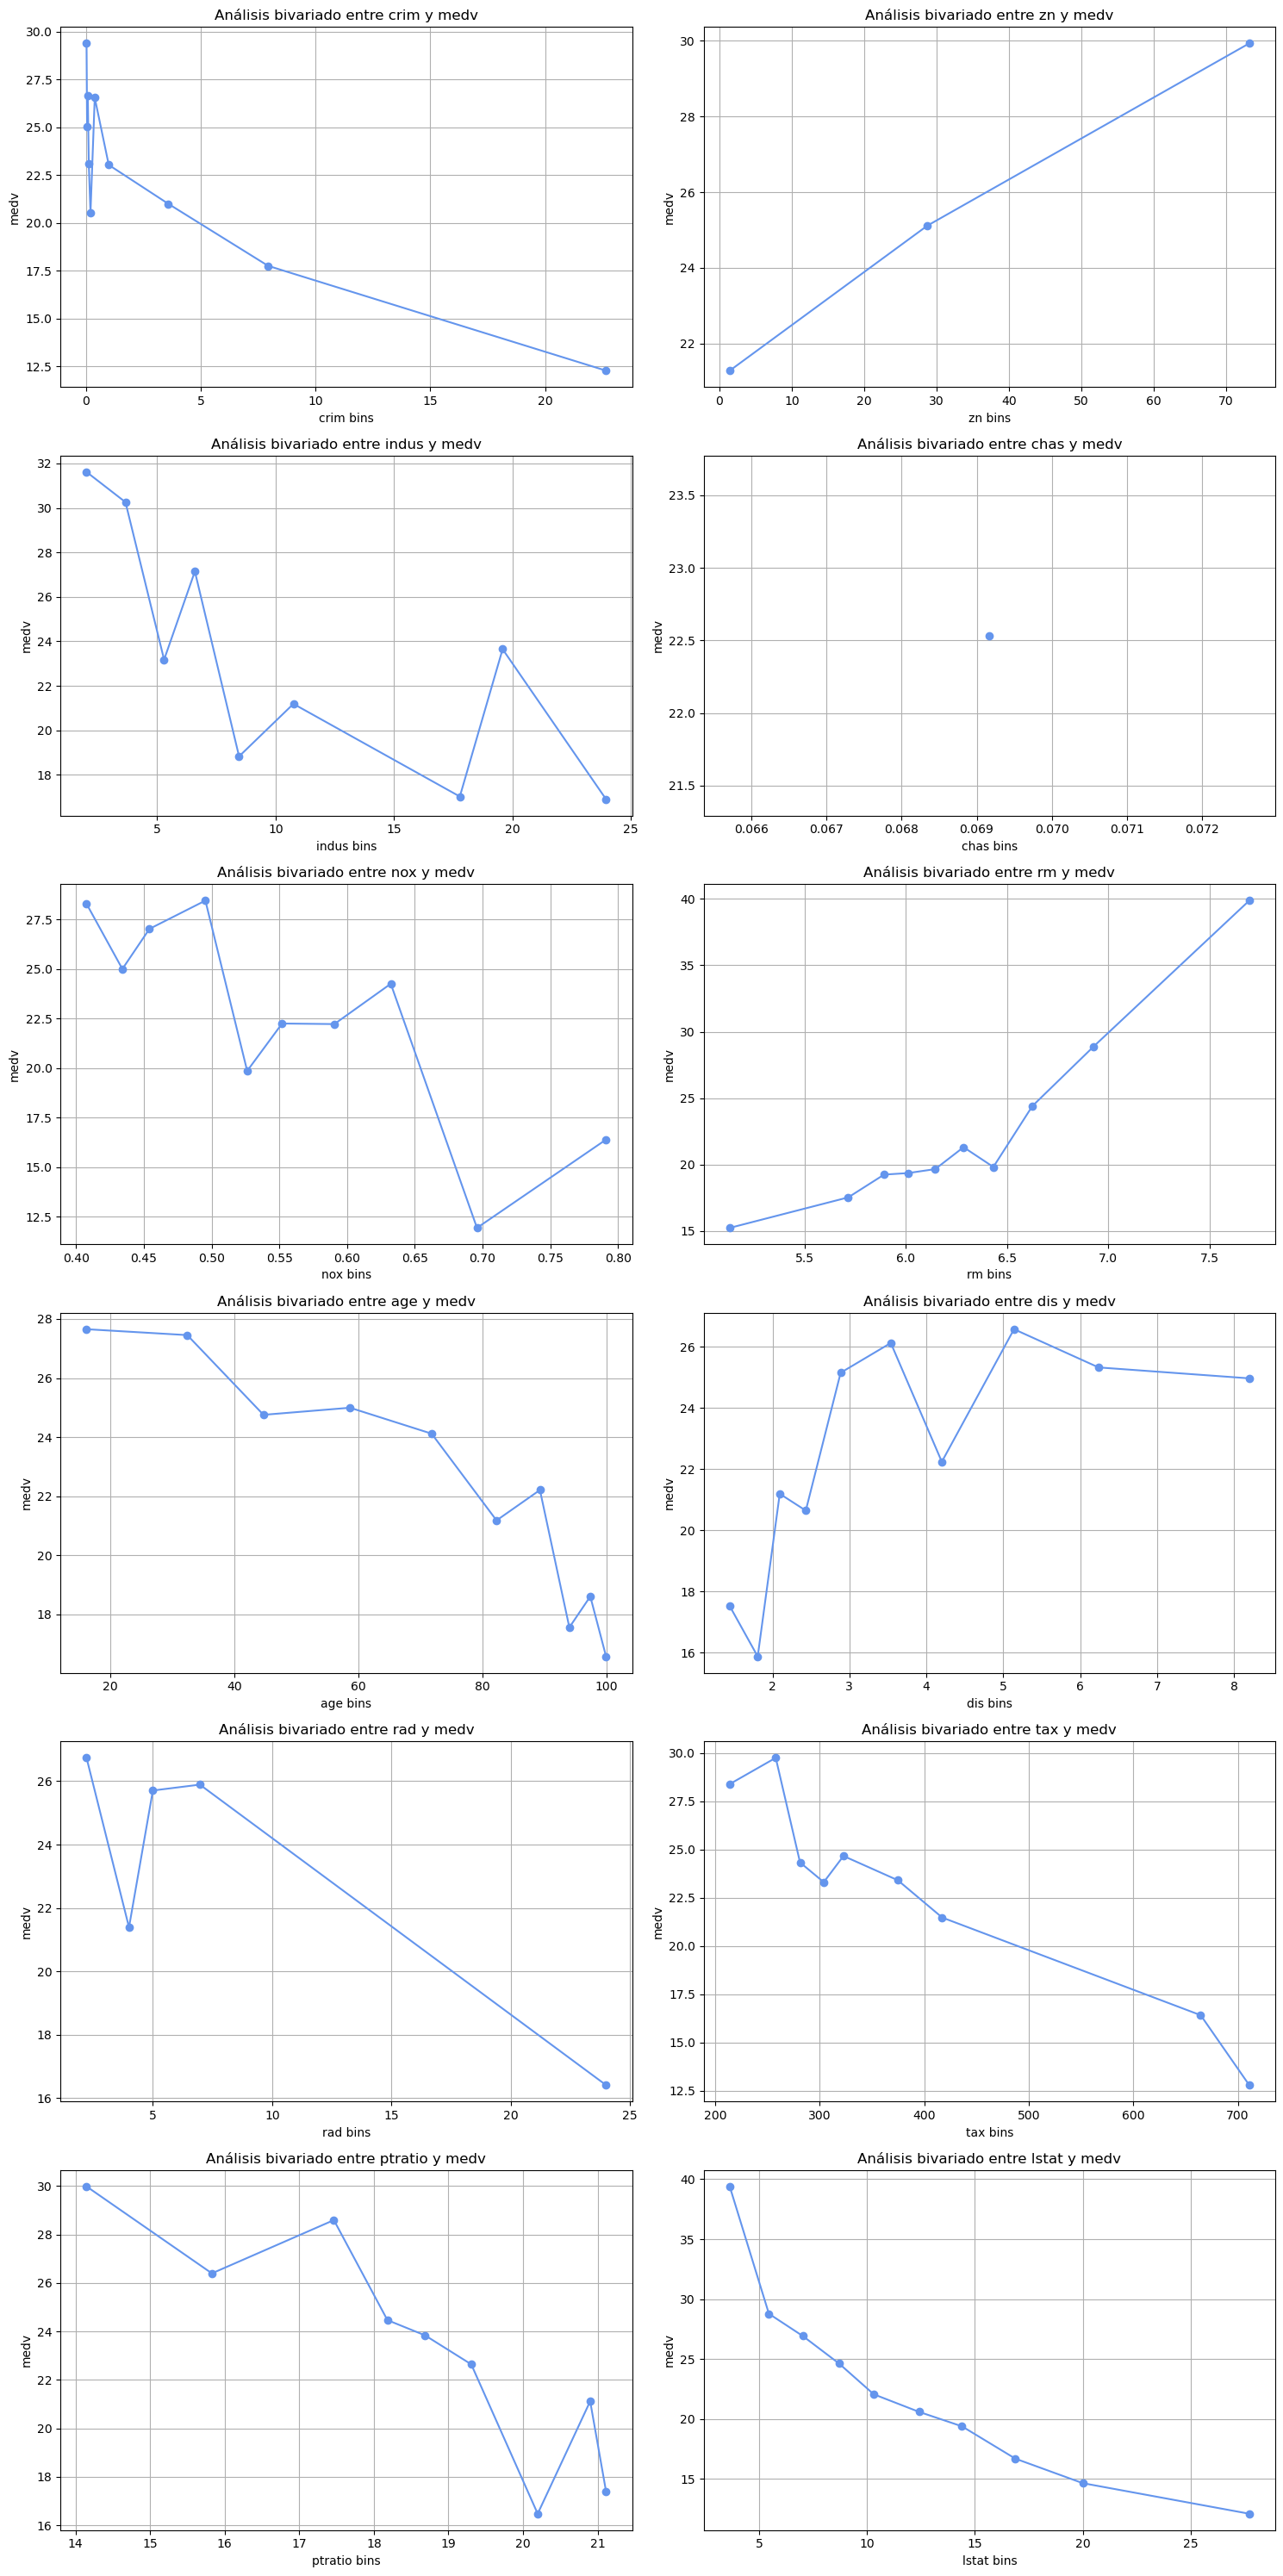

In [20]:
vibariado(data, y)

# Feature engineering

In [21]:
data

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


## Dummies

In [22]:
data = pd.get_dummies(data, columns=['rad'])

## Nuevas Variables

In [23]:
data.iloc[:,12:]

for col in data.iloc[:,12:].columns:  
    data[f'tax_{col}'] = data['tax'] * data[col]  

## Transformaciones

- Logaritmo de la tasa de crimen per capita por ciudad
- Logaritmo de la concentración de óxido nitrico
- Cuadrado de número de cuartos promedio por vivienda
- Raíz de la distancia ponderada de 5 centros de empleo en Boston
- Logaritmo del valor total de la propiedad por la tasa de impuestos por $10,000

In [24]:
data['log_crim'] = np.log(data['crim'])
data['log_nox'] = np.log(data['nox'])
data['rm_2'] = data['rm'] ** 2
data['sqrt_dis'] = np.sqrt(data['dis'])
data['log_tax'] = np.log(data['tax'])

## Análisis vibariado

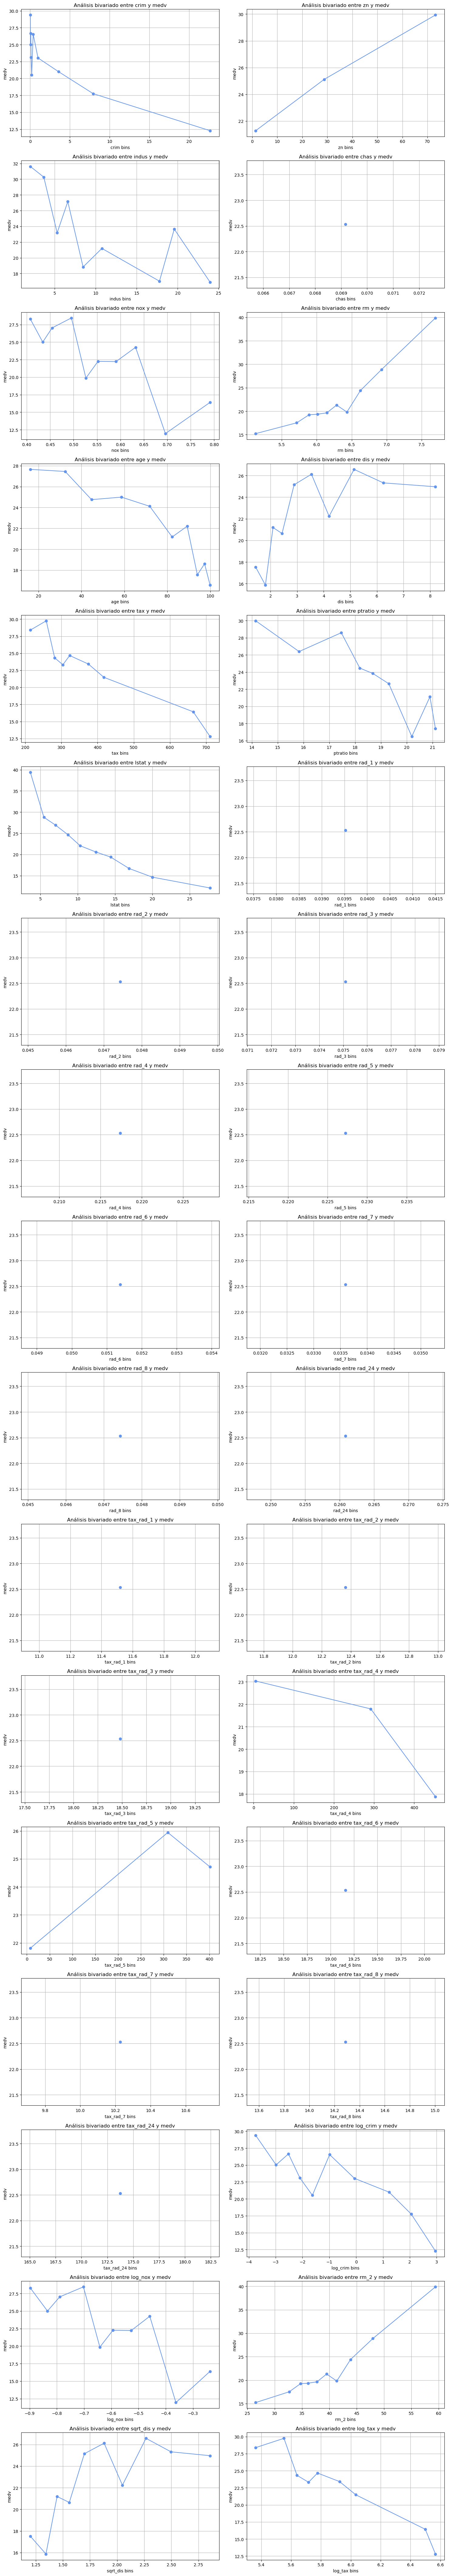

In [25]:
vibariado(data, y)

# Significancia de variables

In [26]:
controls = data.keys().drop(target)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,265.1517,42.132,6.293,0.000,182.363,347.941
rad_1[T.True],37.6573,8.825,4.267,0.000,20.316,54.998
rad_2[T.True],28.5368,6.662,4.283,0.000,15.446,41.628
rad_3[T.True],35.2070,6.357,5.538,0.000,22.715,47.699
rad_4[T.True],38.6511,8.033,4.812,0.000,22.867,54.436
rad_5[T.True],31.2932,6.007,5.209,0.000,19.490,43.097
rad_6[T.True],31.7514,9.047,3.510,0.000,13.975,49.528
rad_7[T.True],30.4615,8.477,3.593,0.000,13.804,47.119
rad_8[T.True],31.5935,24.156,1.308,0.192,-15.873,79.060
rad_24[T.True],7.046e-05,1.19e-05,5.904,0.000,4.7e-05,9.39e-05


In [27]:
controls = controls.drop('indus')
data.drop('indus', axis=1, inplace=True)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,262.7025,41.225,6.372,0.000,181.697,343.708
rad_1[T.True],37.2694,8.713,4.277,0.000,20.148,54.391
rad_2[T.True],27.7320,6.042,4.590,0.000,15.860,39.604
rad_3[T.True],35.1212,6.344,5.536,0.000,22.655,47.587
rad_4[T.True],38.4659,7.999,4.809,0.000,22.747,54.185
rad_5[T.True],31.3175,6.001,5.219,0.000,19.526,43.109
rad_6[T.True],31.3999,8.955,3.506,0.000,13.803,48.997
rad_7[T.True],30.5417,8.465,3.608,0.000,13.909,47.174
rad_8[T.True],30.8548,23.996,1.286,0.199,-16.298,78.007
rad_24[T.True],6.962e-05,1.16e-05,6.023,0.000,4.69e-05,9.23e-05


In [28]:
controls = controls.drop('tax')
data.drop('tax', axis=1, inplace=True)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,262.7025,41.225,6.372,0.000,181.697,343.708
rad_1[T.True],37.2694,8.713,4.277,0.000,20.148,54.391
rad_2[T.True],27.7320,6.042,4.590,0.000,15.860,39.604
rad_3[T.True],35.1212,6.344,5.536,0.000,22.655,47.587
rad_4[T.True],38.4659,7.999,4.809,0.000,22.747,54.185
rad_5[T.True],31.3175,6.001,5.219,0.000,19.526,43.109
rad_6[T.True],31.3998,8.955,3.506,0.000,13.803,48.997
rad_7[T.True],30.5417,8.465,3.608,0.000,13.909,47.174
rad_8[T.True],30.8548,23.996,1.286,0.199,-16.298,78.007
rad_24[T.True],0.0001,4.27e-05,3.216,0.001,5.34e-05,0.000


In [29]:
controls = controls.drop('log_crim')
data.drop('log_crim', axis=1, inplace=True)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,262.5668,41.190,6.374,0.000,181.630,343.504
rad_1[T.True],37.3857,8.703,4.296,0.000,20.285,54.486
rad_2[T.True],27.5738,6.028,4.574,0.000,15.730,39.418
rad_3[T.True],35.2800,6.330,5.573,0.000,22.842,47.718
rad_4[T.True],38.6254,7.986,4.837,0.000,22.934,54.317
rad_5[T.True],31.0702,5.973,5.202,0.000,19.334,42.807
rad_6[T.True],31.8597,8.895,3.582,0.000,14.381,49.338
rad_7[T.True],30.3252,8.445,3.591,0.000,13.731,46.920
rad_8[T.True],30.4466,23.961,1.271,0.204,-16.636,77.530
rad_24[T.True],0.0001,4.25e-05,3.189,0.002,5.2e-05,0.000


In [30]:
controls = controls.drop('age')
data.drop('age', axis=1, inplace=True)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,246.3409,40.401,6.097,0.000,166.956,325.726
rad_1[T.True],35.7507,8.683,4.117,0.000,18.689,52.813
rad_2[T.True],26.5021,6.017,4.404,0.000,14.678,38.326
rad_3[T.True],33.5486,6.281,5.341,0.000,21.207,45.890
rad_4[T.True],36.8173,7.950,4.631,0.000,21.196,52.439
rad_5[T.True],29.9733,5.961,5.028,0.000,18.260,41.686
rad_6[T.True],29.5969,8.839,3.349,0.001,12.230,46.964
rad_7[T.True],28.2247,8.395,3.362,0.001,11.729,44.720
rad_8[T.True],25.9273,23.907,1.084,0.279,-21.049,72.904
rad_24[T.True],0.0001,4.25e-05,3.082,0.002,4.75e-05,0.000


In [31]:
controls = controls.drop('log_nox')
data.drop('log_nox', axis=1, inplace=True)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,198.3802,33.566,5.910,0.000,132.425,264.336
rad_1[T.True],28.0905,7.921,3.546,0.000,12.525,43.656
rad_2[T.True],21.6384,5.581,3.877,0.000,10.671,32.606
rad_3[T.True],27.0997,5.512,4.916,0.000,16.269,37.931
rad_4[T.True],29.7586,7.243,4.109,0.000,15.527,43.990
rad_5[T.True],25.4874,5.591,4.558,0.000,14.501,36.474
rad_6[T.True],21.3382,7.959,2.681,0.008,5.699,36.977
rad_7[T.True],22.0663,7.903,2.792,0.005,6.537,37.595
rad_8[T.True],22.9010,23.951,0.956,0.339,-24.161,69.963
rad_24[T.True],0.0001,4.14e-05,2.637,0.009,2.78e-05,0.000


In [32]:
controls = controls.drop('zn')
data.drop('zn', axis=1, inplace=True)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,207.5600,32.255,6.435,0.000,144.181,270.939
rad_1[T.True],30.1786,7.634,3.953,0.000,15.177,45.180
rad_2[T.True],21.5250,5.580,3.857,0.000,10.560,32.490
rad_3[T.True],27.1644,5.512,4.929,0.000,16.335,37.994
rad_4[T.True],31.1574,7.103,4.387,0.000,17.201,45.114
rad_5[T.True],26.1699,5.549,4.717,0.000,15.267,37.072
rad_6[T.True],22.5205,7.868,2.862,0.004,7.059,37.981
rad_7[T.True],24.0085,7.655,3.136,0.002,8.968,39.049
rad_8[T.True],24.8356,23.870,1.040,0.299,-22.068,71.739
rad_24[T.True],0.0001,4.05e-05,2.917,0.004,3.85e-05,0.000


# Preparación de datos

## Cross validation

In [33]:
X = data.copy().drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Scaler

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Regresión lineal múltiple

## Modelo normal

In [35]:
model = linear_model.LinearRegression().fit(X_train_scaled, y_train)
predicciones_RLM = model.predict(X_test_scaled)

r2 = r2_score(y_true=y_test, y_pred=predicciones_RLM)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_RLM)
print(f"MSE: {mse:,.4f}")

coeficientes = pd.DataFrame({
     'names': X.keys(),
     'coeficientes': model.coef_
})

print()
print(f"Intercepto del modelo: {model.intercept_:,.2f}\nCoeficientes del modelo:")
display(coeficientes)

R² Score: 0.8224
MSE: 13.2316

Intercepto del modelo: 23.02
Coeficientes del modelo:


,names,coeficientes
0,crim,-1.687134
1,chas,0.659659
2,nox,-2.772980
3,rm,-17.593577
4,dis,7.624252
5,ptratio,-1.754777
6,lstat,-4.453342
7,rad_1,0.491970
8,rad_2,-1.220747
9,rad_3,-0.277439


### Calibración

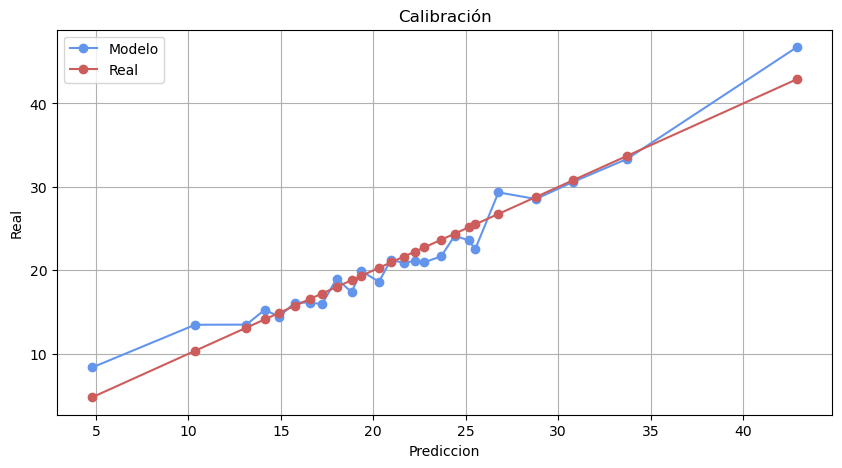

In [36]:
calibracion(predicciones_RLM, y_test, 25)

## Regularización Ridge

In [37]:
model = linear_model.Ridge().fit(X_train_scaled, y_train)
predicciones_RLM_ridge = model.predict(X_test_scaled)

r2 = r2_score(y_true=y_test, y_pred=predicciones_RLM_ridge)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_RLM_ridge)
print(f"MSE: {mse:,.4f}")

coeficientes = pd.DataFrame({
     'names': X.keys(),
     'coeficientes': model.coef_
})

print()
print(f"Intercepto del modelo: {model.intercept_:,.2f}\nCoeficientes del modelo:")
display(coeficientes)

R² Score: 0.8032
MSE: 14.6667

Intercepto del modelo: 23.02
Coeficientes del modelo:


,names,coeficientes
0,crim,-1.540212
1,chas,0.736965
2,nox,-2.645103
3,rm,-10.524638
4,dis,5.439224
5,ptratio,-1.992591
6,lstat,-4.322717
7,rad_1,0.863681
8,rad_2,-0.374692
9,rad_3,0.232100


### Calibración

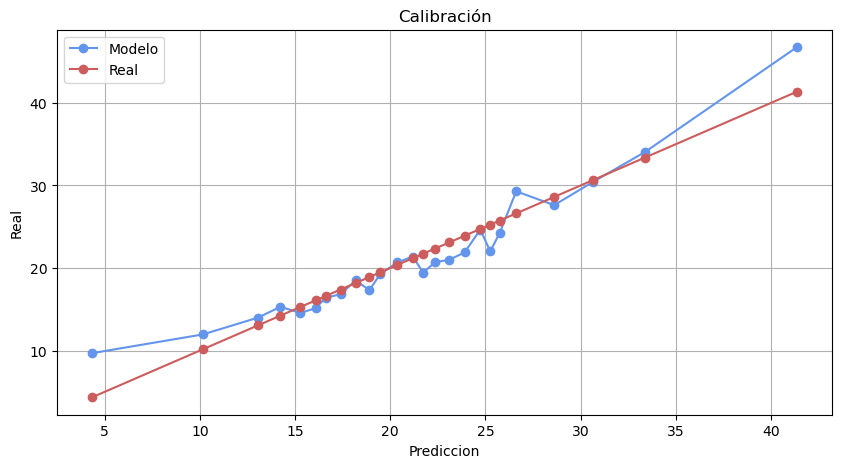

In [38]:
calibracion(predicciones_RLM_ridge, y_test, 25)

## Regularización Lasso

In [39]:
model = linear_model.Lasso().fit(X_train_scaled, y_train)
predicciones_RLM_lasso = model.predict(X_test_scaled)

r2 = r2_score(y_true=y_test, y_pred=predicciones_RLM_lasso)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_RLM_lasso)
print(f"MSE: {mse:,.4f}")

coeficientes = pd.DataFrame({
     'names': X.keys(),
     'coeficientes': model.coef_
})

print()
print(f"Intercepto del modelo: {model.intercept_:,.2f}\nCoeficientes del modelo:")
display(coeficientes)

R² Score: 0.6640
MSE: 25.0362

Intercepto del modelo: 23.02
Coeficientes del modelo:


,names,coeficientes
0,crim,-0.109345
1,chas,0.183187
2,nox,-0.000000
3,rm,0.000000
4,dis,-0.000000
5,ptratio,-1.155314
6,lstat,-3.691758
7,rad_1,-0.000000
8,rad_2,0.000000
9,rad_3,0.000000


### Calibración

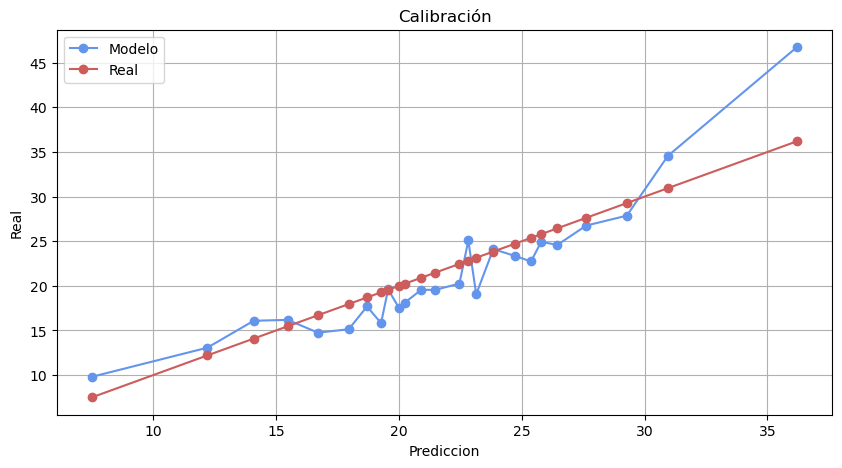

In [40]:
calibracion(predicciones_RLM_lasso, y_test, 25)

## Comparación modelos

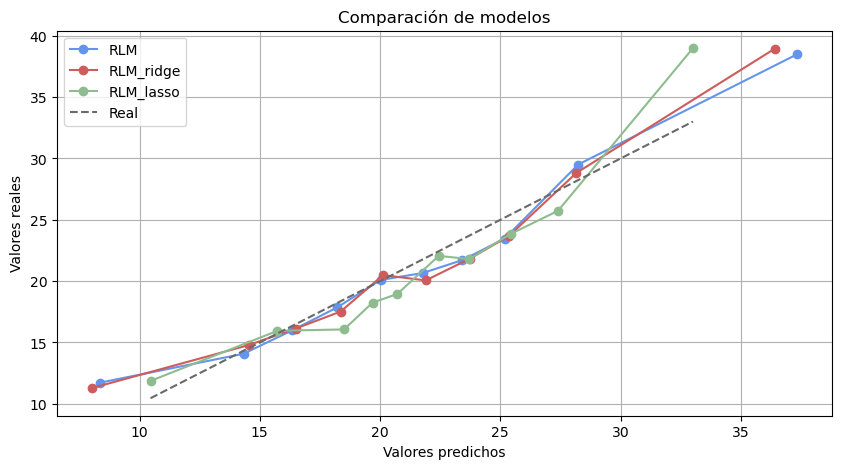

In [41]:
modelos = ['RLM', 'RLM_ridge', 'RLM_lasso']

comparacion(modelos, y_test)

# Regresión polinomial

## Grado 2

In [42]:
degree = 2

poly_features = PolynomialFeatures(degree=degree)
X_poly_train = poly_features.fit_transform(X_train_scaled)
X_poly_test = poly_features.fit_transform(X_test_scaled)

### Modelo Normal

In [43]:
model = linear_model.LinearRegression().fit(X_poly_train, y_train)
predicciones_poly2 = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly2)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly2)
print(f"MSE: {mse:,.4f}")

R² Score: -143,119,012,969,020,424,192.0000
MSE: 10,664,240,690,939,419,426,816.0000


#### Calibración

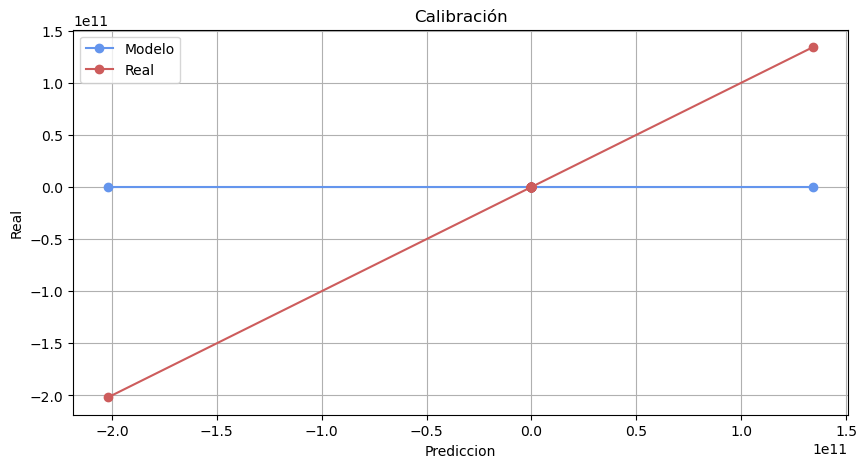

In [44]:
calibracion(predicciones_poly2, y_test, 25)

### Regularización Ridge

In [45]:
model = linear_model.Ridge().fit(X_poly_train, y_train)
predicciones_poly2_ridge = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly2_ridge)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly2_ridge)
print(f"MSE: {mse:,.4f}")

R² Score: 0.8388
MSE: 12.0099


#### Calibración

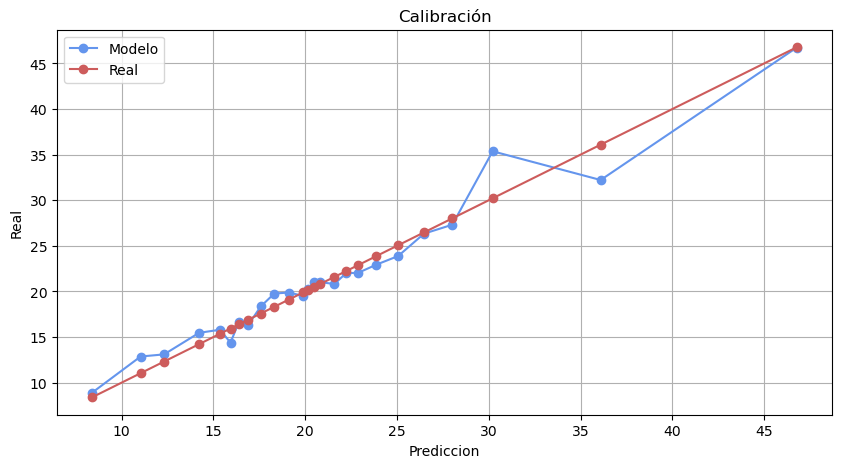

In [46]:
calibracion(predicciones_poly2_ridge, y_test, 25)

### Regularización Lasso

In [47]:
model = linear_model.Lasso().fit(X_poly_train, y_train)
predicciones_poly2_lasso = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly2_lasso)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly2_lasso)
print(f"MSE: {mse:,.4f}")

R² Score: 0.7541
MSE: 18.3257


#### Calibración

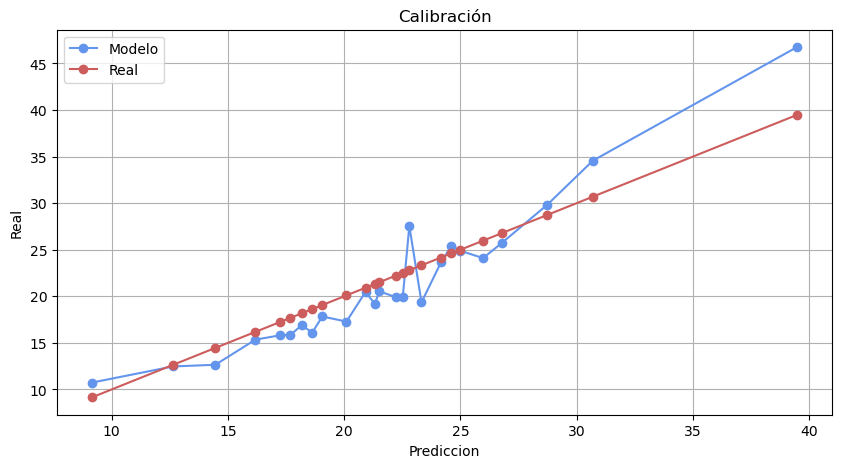

In [48]:
calibracion(predicciones_poly2_lasso, y_test, 25)

### Comparación modelos

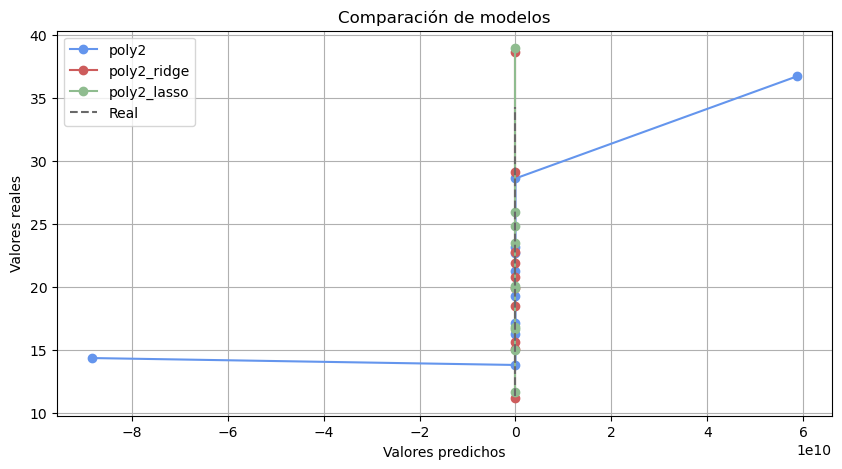

In [49]:
modelos = ['poly2', 'poly2_ridge', 'poly2_lasso']

comparacion(modelos, y_test)

## Grado 3

In [50]:
degree = 3

poly_features = PolynomialFeatures(degree=degree)
X_poly_train = poly_features.fit_transform(X_train_scaled)
X_poly_test = poly_features.fit_transform(X_test_scaled)

### Modelo Normal

In [51]:
model = linear_model.LinearRegression().fit(X_poly_train, y_train)
predicciones_poly3 = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly3)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly3)
print(f"MSE: {mse:,.4f}")

R² Score: -6,835.5463
MSE: 509,412.2284


#### Calibración

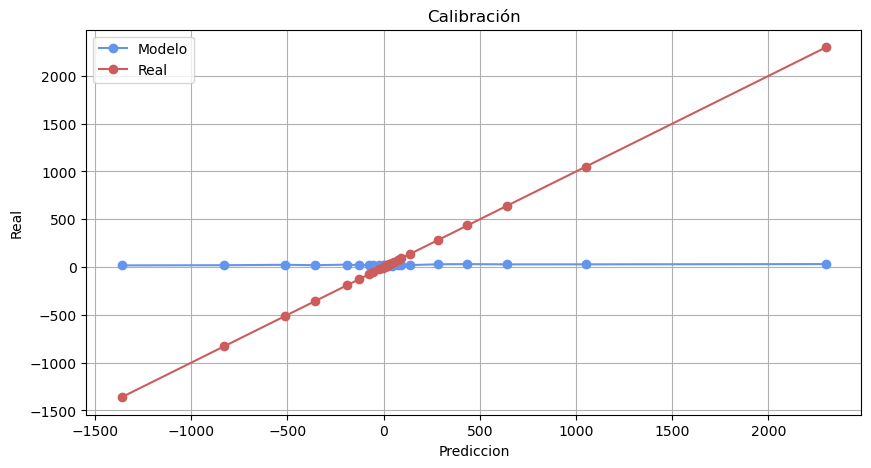

In [52]:
calibracion(predicciones_poly3, y_test, 25)

### Regularización Ridge

In [53]:
model = linear_model.Ridge().fit(X_poly_train, y_train)
predicciones_poly3_ridge = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly3_ridge)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly3_ridge)
print(f"MSE: {mse:,.4f}")

R² Score: 0.2631
MSE: 54.9074


#### Calibración

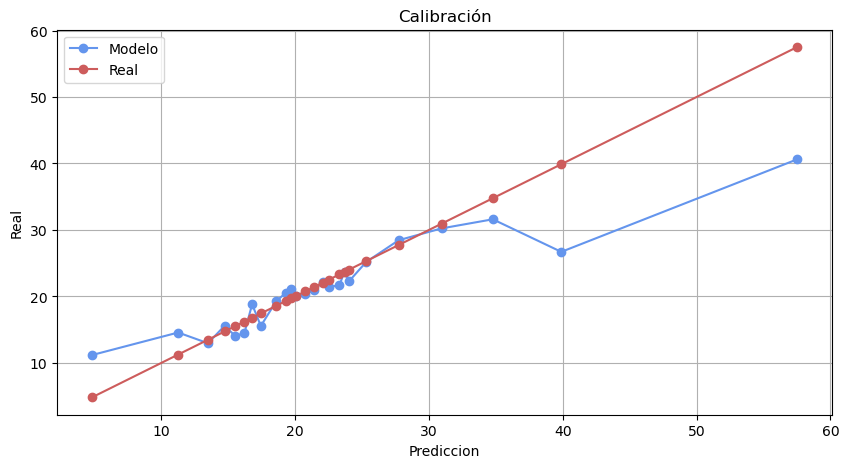

In [54]:
calibracion(predicciones_poly3_ridge, y_test, 25)

### Regularización Lasso

In [55]:
model = linear_model.Lasso().fit(X_poly_train, y_train)
predicciones_poly3_lasso = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly3_lasso)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly3_lasso)
print(f"MSE: {mse:,.4f}")

R² Score: 0.6945
MSE: 22.7634


#### Calibración

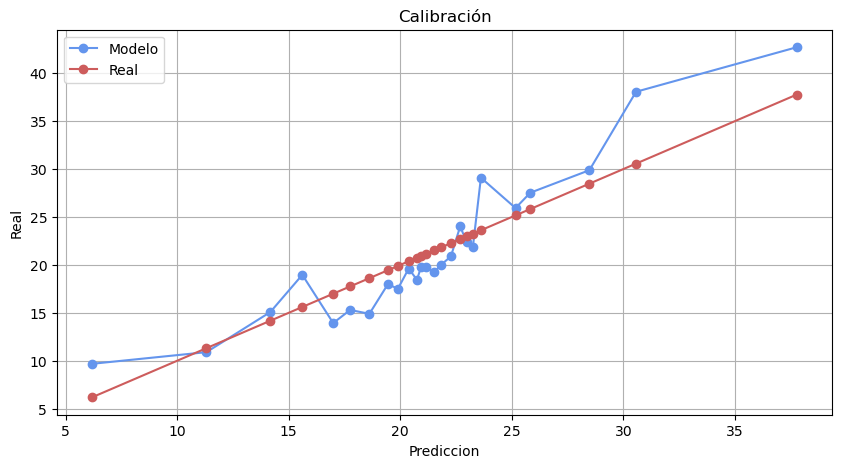

In [56]:
calibracion(predicciones_poly3_lasso, y_test, 25)

### Comparación modelos

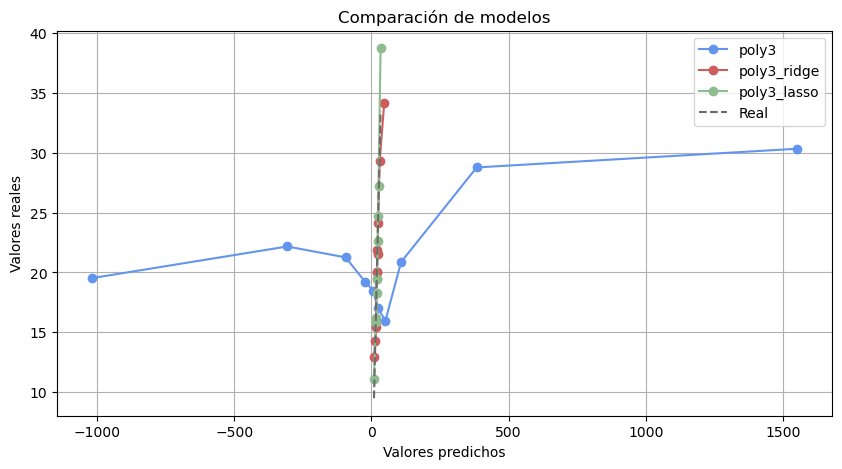

In [57]:
modelos = ['poly3', 'poly3_ridge', 'poly3_lasso']

comparacion(modelos, y_test)

# KNN

## Aproximación gráfica

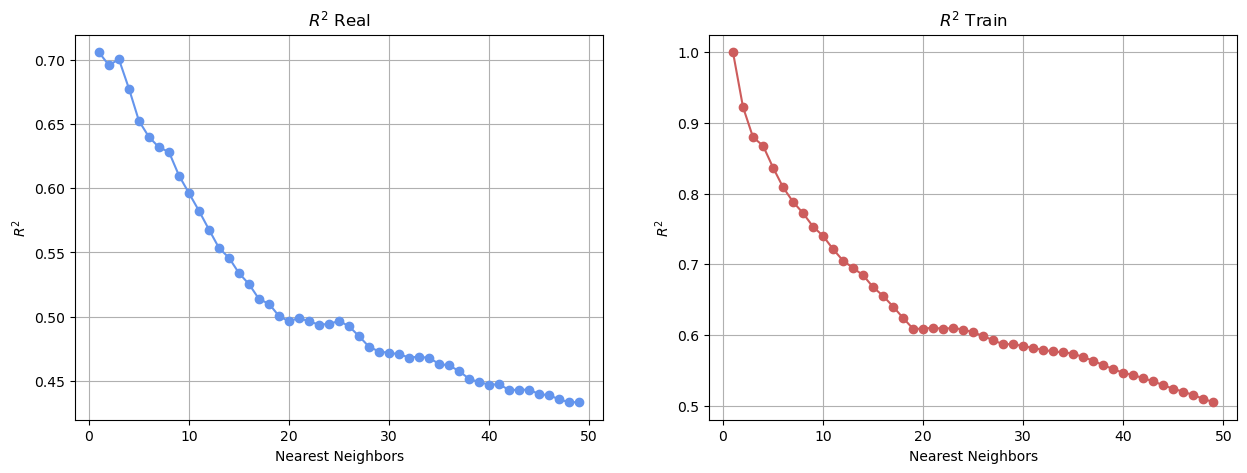

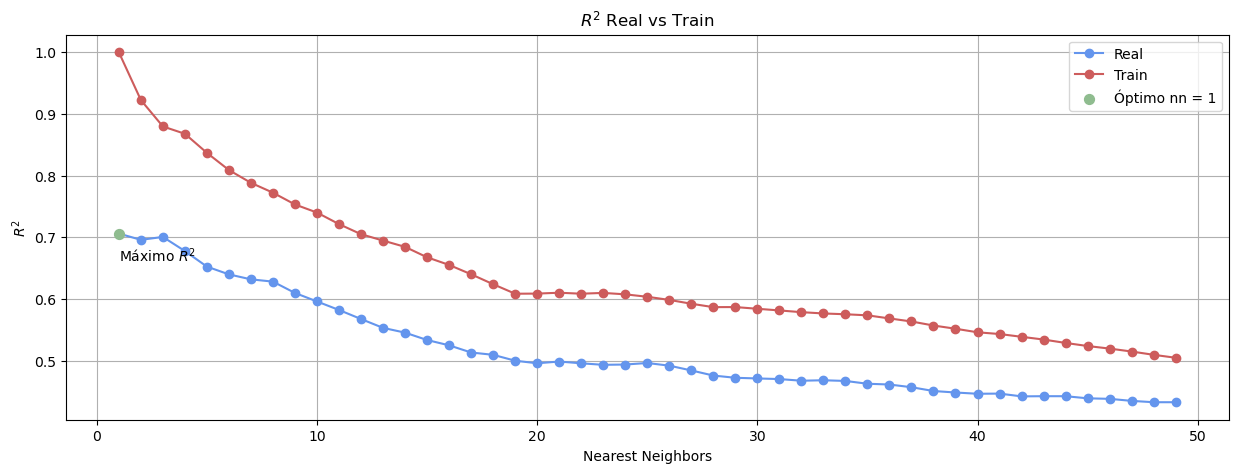

In [66]:
nn = []
r2 = []
r2_train = []
for i in range(1, 50):
    
    model = KNeighborsRegressor(n_neighbors=i).fit(X_train_scaled, y_train)
    predicciones = model.predict(X_test_scaled)

    r2.append(r2_score(y_true=y_test, y_pred=predicciones))
    nn.append(i)

    predicciones_train = model.predict(X_train_scaled)
    r2_train.append(r2_score(y_true=y_train, y_pred=predicciones_train))

resultados = pd.DataFrame({'r2': r2, 'nn': nn, 'r2_train': r2_train})

nn_opt = resultados[resultados.r2 == max(resultados.r2)].nn.values[0]

graficas_KNN(resultados, nn_opt)

## Prueba y error

In [67]:
model = KNeighborsRegressor(n_neighbors=nn_opt-1 if nn_opt > 1 else nn_opt).fit(X_train_scaled, y_train)
predicciones = model.predict(X_test_scaled)
nn_opt_nbr_minus = r2_score(y_true=y_test, y_pred=predicciones)

model = KNeighborsRegressor(n_neighbors=nn_opt).fit(X_train_scaled, y_train)
predicciones = model.predict(X_test_scaled)
nn_opt_nbr = r2_score(y_true=y_test, y_pred=predicciones)

model = KNeighborsRegressor(n_neighbors=nn_opt+1).fit(X_train_scaled, y_train)
predicciones = model.predict(X_test_scaled)
nn_opt_nbr_plus = r2_score(y_true=y_test, y_pred=predicciones)

print(f"R2 con {nn_opt-1 if nn_opt > 1 else nn_opt} neighbors: {nn_opt_nbr_minus:.4f} \nR2 con {nn_opt} neighbors: {nn_opt_nbr:.4f} \nR2 con {nn_opt+1} neighbors: {nn_opt_nbr_plus:.4f}")

R2 con 1 neighbors: 0.7063 
R2 con 1 neighbors: 0.7063 
R2 con 2 neighbors: 0.6961


# Conclusiones generales